This is a companion notebook for the book [Deep Learning with Python, Second Edition](https://www.manning.com/books/deep-learning-with-python-second-edition?a_aid=keras&a_bid=76564dff). For readability, it only contains runnable code blocks and section titles, and omits everything else in the book: text paragraphs, figures, and pseudocode.

**If you want to be able to follow what's going on, I recommend reading the notebook side by side with your copy of the book.**

This notebook was generated for TensorFlow 2.6.

# Deep learning for timeseries

## Different kinds of timeseries tasks

## A temperature-forecasting example

In [1]:
!wget https://s3.amazonaws.com/keras-datasets/jena_climate_2009_2016.csv.zip
!unzip jena_climate_2009_2016.csv.zip

--2022-04-02 02:47:49--  https://s3.amazonaws.com/keras-datasets/jena_climate_2009_2016.csv.zip
Resolving s3.amazonaws.com (s3.amazonaws.com)... 52.216.105.77
Connecting to s3.amazonaws.com (s3.amazonaws.com)|52.216.105.77|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 13565642 (13M) [application/zip]
Saving to: ‘jena_climate_2009_2016.csv.zip’

jena_climate_2009_2 100%[===================>]  12.94M  36.1MB/s    in 0.4s    

2022-04-02 02:47:49 (36.1 MB/s) - ‘jena_climate_2009_2016.csv.zip’ saved [13565642/13565642]

Archive:  jena_climate_2009_2016.csv.zip
  inflating: jena_climate_2009_2016.csv  
  inflating: __MACOSX/._jena_climate_2009_2016.csv  


**Inspecting the data of the Jena weather dataset**

In [2]:
import os
fname = os.path.join("jena_climate_2009_2016.csv")

with open(fname) as f:
    data = f.read()

lines = data.split("\n")
header = lines[0].split(",")
lines = lines[1:]
print(header)
print(len(lines))

['"Date Time"', '"p (mbar)"', '"T (degC)"', '"Tpot (K)"', '"Tdew (degC)"', '"rh (%)"', '"VPmax (mbar)"', '"VPact (mbar)"', '"VPdef (mbar)"', '"sh (g/kg)"', '"H2OC (mmol/mol)"', '"rho (g/m**3)"', '"wv (m/s)"', '"max. wv (m/s)"', '"wd (deg)"']
420451


**Parsing the data**

In [3]:
import numpy as np
temperature = np.zeros((len(lines),))
raw_data = np.zeros((len(lines), len(header) - 1))
for i, line in enumerate(lines):
    values = [float(x) for x in line.split(",")[1:]]
    temperature[i] = values[1]
    raw_data[i, :] = values[:]

In [4]:
print(type(temperature))
import pandas as pd
df = pd.read_csv('/content/jena_climate_2009_2016.csv')
df.set_index('Date Time', inplace=True)

<class 'numpy.ndarray'>


<class 'pandas.core.frame.DataFrame'>
Index: 420451 entries, 01.01.2009 00:10:00 to 01.01.2017 00:00:00
Data columns (total 14 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   p (mbar)         420451 non-null  float64
 1   T (degC)         420451 non-null  float64
 2   Tpot (K)         420451 non-null  float64
 3   Tdew (degC)      420451 non-null  float64
 4   rh (%)           420451 non-null  float64
 5   VPmax (mbar)     420451 non-null  float64
 6   VPact (mbar)     420451 non-null  float64
 7   VPdef (mbar)     420451 non-null  float64
 8   sh (g/kg)        420451 non-null  float64
 9   H2OC (mmol/mol)  420451 non-null  float64
 10  rho (g/m**3)     420451 non-null  float64
 11  wv (m/s)         420451 non-null  float64
 12  max. wv (m/s)    420451 non-null  float64
 13  wd (deg)         420451 non-null  float64
dtypes: float64(14)
memory usage: 48.1+ MB
                     p (mbar)  T (degC)  Tpot (K)  Tdew (degC)  rh (

(array([-200.,    0.,  200.,  400.,  600.,  800., 1000., 1200., 1400.,
        1600.]), <a list of 10 Text major ticklabel objects>)

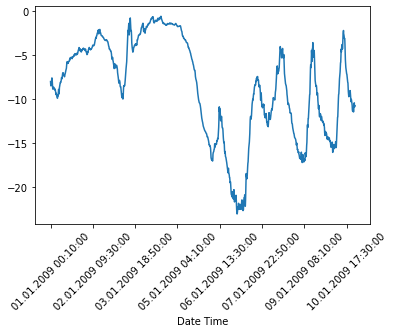

In [16]:
df.info()
print(df.head())
import matplotlib.pyplot as plt

df['T (degC)'][:1440].plot()
plt.xticks(rotation=45)

**Plotting the temperature timeseries**

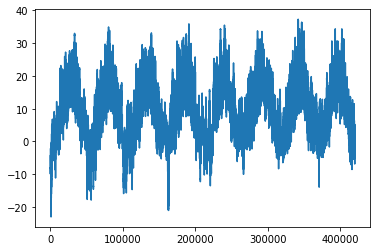

In [6]:
from matplotlib import pyplot as plt
plt.plot(range(len(temperature)), temperature)

**Plotting the first 10 days of the temperature timeseries**

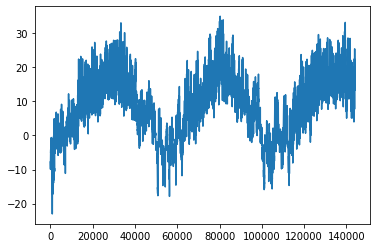

In [18]:
plt.plot(range(144000), temperature[:144000])

**Computing the number of samples we'll use for each data split**

In [8]:
num_train_samples = int(0.5 * len(raw_data))
num_val_samples = int(0.25 * len(raw_data))
num_test_samples = len(raw_data) - num_train_samples - num_val_samples
print("num_train_samples:", num_train_samples)
print("num_val_samples:", num_val_samples)
print("num_test_samples:", num_test_samples)

num_train_samples: 210225
num_val_samples: 105112
num_test_samples: 105114


In [ ]:
print()

### Preparing the data

**Normalizing the data**

In [9]:
mean = raw_data[:num_train_samples].mean(axis=0)
raw_data -= mean
std = raw_data[:num_train_samples].std(axis=0)
raw_data /= std

In [10]:
import numpy as np
from tensorflow import keras
int_sequence = np.arange(10)
dummy_dataset = keras.utils.timeseries_dataset_from_array(
    data=int_sequence[:-3],
    targets=int_sequence[3:],
    sequence_length=3,
    batch_size=2,
)

for inputs, targets in dummy_dataset:
    for i in range(inputs.shape[0]):
        print([int(x) for x in inputs[i]], int(targets[i]))

[0, 1, 2] 3
[1, 2, 3] 4
[2, 3, 4] 5
[3, 4, 5] 6
[4, 5, 6] 7


**Instantiating datasets for training, validation, and testing**

In [11]:
sampling_rate = 6
sequence_length = 120
delay = sampling_rate * (sequence_length + 24 - 1)
batch_size = 256

train_dataset = keras.utils.timeseries_dataset_from_array(
    raw_data[:-delay],
    targets=temperature[delay:],
    sampling_rate=sampling_rate,
    sequence_length=sequence_length,
    shuffle=True,
    batch_size=batch_size,
    start_index=0,
    end_index=num_train_samples)

val_dataset = keras.utils.timeseries_dataset_from_array(
    raw_data[:-delay],
    targets=temperature[delay:],
    sampling_rate=sampling_rate,
    sequence_length=sequence_length,
    shuffle=True,
    batch_size=batch_size,
    start_index=num_train_samples,
    end_index=num_train_samples + num_val_samples)

test_dataset = keras.utils.timeseries_dataset_from_array(
    raw_data[:-delay],
    targets=temperature[delay:],
    sampling_rate=sampling_rate,
    sequence_length=sequence_length,
    shuffle=True,
    batch_size=batch_size,
    start_index=num_train_samples + num_val_samples)

**Inspecting the output of one of our datasets**

In [12]:
for samples, targets in train_dataset:
    print("samples shape:", samples.shape)
    print("targets shape:", targets.shape)
    break

samples shape: (256, 120, 14)
targets shape: (256,)


### A common-sense, non-machine-learning baseline

**Computing the common-sense baseline MAE**

In [26]:
def evaluate_naive_method(dataset):
    total_abs_err = 0.
    samples_seen = 0
    for samples, targets in dataset:
        preds = samples[:, -1, 1] * std[1] + mean[1]
        total_abs_err += np.sum(np.abs(preds - targets))
        samples_seen += samples.shape[0]
    return total_abs_err / samples_seen

print(f"Validation MAE: {evaluate_naive_method(val_dataset):.2f}")
print(f"Test MAE: {evaluate_naive_method(test_dataset):.2f}")

Validation MAE: 2.44
Test MAE: 2.62


### Let's try a basic machine-learning model

**Training and evaluating a densely connected model**

In [14]:
from tensorflow import keras
from tensorflow.keras import layers

In [27]:
inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.Flatten()(inputs)
x = layers.Dense(16, activation="relu")(x)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

callbacks = [
    keras.callbacks.ModelCheckpoint("jena_dense.keras",
                                    save_best_only=True)
]
model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(train_dataset,
                    epochs=10,
                    validation_data=val_dataset,
                    callbacks=callbacks)

model = keras.models.load_model("jena_dense.keras")
print(f"Test MAE: {model.evaluate(test_dataset)[1]:.2f}")

Epoch 1/10
819/819 [==============================] - 64s 77ms/step - loss: 13.7638 - mae: 2.8684 - val_loss: 12.4161 - val_mae: 2.7866
Epoch 2/10
819/819 [==============================] - 63s 76ms/step - loss: 9.6811 - mae: 2.4532 - val_loss: 10.3885 - val_mae: 2.5549
Epoch 3/10
819/819 [==============================] - 65s 79ms/step - loss: 8.9563 - mae: 2.3620 - val_loss: 11.5035 - val_mae: 2.6785
Epoch 4/10
819/819 [==============================] - 64s 77ms/step - loss: 8.4418 - mae: 2.2942 - val_loss: 12.9335 - val_mae: 2.8581
Epoch 5/10
819/819 [==============================] - 66s 80ms/step - loss: 8.0480 - mae: 2.2387 - val_loss: 10.6595 - val_mae: 2.5770
Epoch 6/10
819/819 [==============================] - 67s 81ms/step - loss: 7.7598 - mae: 2.1984 - val_loss: 10.4211 - val_mae: 2.5512
Epoch 7/10
819/819 [==============================] - 67s 81ms/step - loss: 7.5726 - mae: 2.1718 - val_loss: 10.7508 - val_mae: 2.5924
Epoch 8/10
819/819 [==============================] - 

**Plotting results**

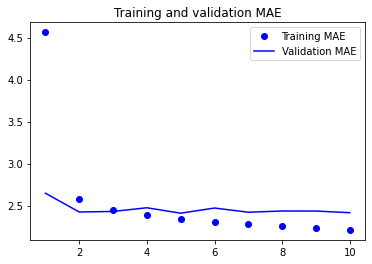

<Figure size 432x288 with 0 Axes>

In [24]:
import matplotlib.pyplot as plt
loss = history.history["mae"]
val_loss = history.history["val_mae"]
epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, loss, "bo", label="Training MAE")
plt.plot(epochs, val_loss, "b", label="Validation MAE")
plt.title("Training and validation MAE")
plt.legend()
plt.show()
plt.savefig('LSTM16-MAE.png')

### Let's try a 1D convolutional model

In [20]:
inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.Conv1D(8, 24, activation="relu")(inputs)
x = layers.MaxPooling1D(2)(x)
x = layers.Conv1D(8, 12, activation="relu")(x)
x = layers.MaxPooling1D(2)(x)
x = layers.Conv1D(8, 6, activation="relu")(x)
x = layers.GlobalAveragePooling1D()(x)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

callbacks = [
    keras.callbacks.ModelCheckpoint("jena_conv.keras",
                                    save_best_only=True)
]
model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(train_dataset,
                    epochs=10,
                    validation_data=val_dataset,
                    callbacks=callbacks)

model = keras.models.load_model("jena_conv.keras")
print(f"Test MAE: {model.evaluate(test_dataset)[1]:.2f}")

Epoch 1/10
819/819 [==============================] - 65s 78ms/step - loss: 21.3597 - mae: 3.6342 - val_loss: 16.1042 - val_mae: 3.1440
Epoch 2/10
819/819 [==============================] - 64s 77ms/step - loss: 15.7866 - mae: 3.1482 - val_loss: 14.8666 - val_mae: 3.0242
Epoch 3/10
819/819 [==============================] - 65s 78ms/step - loss: 14.3128 - mae: 2.9870 - val_loss: 13.8070 - val_mae: 2.9404
Epoch 4/10
819/819 [==============================] - 65s 78ms/step - loss: 13.3816 - mae: 2.8795 - val_loss: 14.3196 - val_mae: 2.9844
Epoch 5/10
819/819 [==============================] - 64s 78ms/step - loss: 12.8075 - mae: 2.8136 - val_loss: 15.8005 - val_mae: 3.1507
Epoch 6/10
819/819 [==============================] - 64s 78ms/step - loss: 12.4181 - mae: 2.7714 - val_loss: 14.5628 - val_mae: 2.9906
Epoch 7/10
359/819 [============>.................] - ETA: 25s - loss: 12.2170 - mae: 2.7470

KeyboardInterrupt: ignored

### A first recurrent baseline

**A simple LSTM-based model**

In [23]:
inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.LSTM(16)(inputs)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

callbacks = [
    keras.callbacks.ModelCheckpoint("jena_lstm.keras",
                                    save_best_only=True)
]
model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(train_dataset,
                    epochs=10,
                    validation_data=val_dataset,
                    callbacks=callbacks)

model = keras.models.load_model("jena_lstm.keras")
print(f"Test MAE: {model.evaluate(test_dataset)[1]:.2f}")

Epoch 1/10
819/819 [==============================] - 82s 97ms/step - loss: 24.1555 - mae: 3.5148 - val_loss: 10.0746 - val_mae: 2.4484
Epoch 2/10
 60/819 [=>............................] - ETA: 47s - loss: 10.1381 - mae: 2.4858

KeyboardInterrupt: ignored

## Understanding recurrent neural networks

**NumPy implementation of a simple RNN**

In [25]:
import numpy as np
timesteps = 100
input_features = 32
output_features = 64
inputs = np.random.random((timesteps, input_features))
state_t = np.zeros((output_features,))
W = np.random.random((output_features, input_features))
U = np.random.random((output_features, output_features))
b = np.random.random((output_features,))
successive_outputs = []
for input_t in inputs:
    output_t = np.tanh(np.dot(W, input_t) + np.dot(U, state_t) + b)
    successive_outputs.append(output_t)
    state_t = output_t
final_output_sequence = np.stack(successive_outputs, axis=0)

### A recurrent layer in Keras

**An RNN layer that can process sequences of any length**

In [26]:
num_features = 14
inputs = keras.Input(shape=(None, num_features))
outputs = layers.SimpleRNN(16)(inputs)

**An RNN layer that returns only its last output step**

In [27]:
num_features = 14
steps = 120
inputs = keras.Input(shape=(steps, num_features))
outputs = layers.SimpleRNN(16, return_sequences=False)(inputs)
print(outputs.shape)

(None, 16)


**An RNN layer that returns its full output sequence**

In [ ]:
num_features = 14
steps = 120
inputs = keras.Input(shape=(steps, num_features))
outputs = layers.SimpleRNN(16, return_sequences=True)(inputs)
print(outputs.shape)

**Stacking RNN layers**

In [28]:
inputs = keras.Input(shape=(steps, num_features))
x = layers.SimpleRNN(16, return_sequences=True)(inputs)
x = layers.SimpleRNN(16, return_sequences=True)(x)
outputs = layers.SimpleRNN(16)(x)

## Advanced use of recurrent neural networks

### Using recurrent dropout to fight overfitting

**Training and evaluating a dropout-regularized LSTM**

In [ ]:
inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.LSTM(32, recurrent_dropout=0.25)(inputs)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

callbacks = [
    keras.callbacks.ModelCheckpoint("jena_lstm_dropout.keras",
                                    save_best_only=True)
]
model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(train_dataset,
                    epochs=50,
                    validation_data=val_dataset,
                    callbacks=callbacks)

Epoch 1/50
819/819 [==============================] - 515s 625ms/step - loss: 27.4189 - mae: 3.8625 - val_loss: 9.8150 - val_mae: 2.4356
Epoch 2/50
819/819 [==============================] - 506s 617ms/step - loss: 14.7116 - mae: 2.9776 - val_loss: 9.3395 - val_mae: 2.3688
Epoch 3/50
819/819 [==============================] - 498s 608ms/step - loss: 13.7885 - mae: 2.8808 - val_loss: 9.3641 - val_mae: 2.3657
Epoch 4/50
513/819 [=================>............] - ETA: 2:53 - loss: 13.1588 - mae: 2.8171

In [ ]:
inputs = keras.Input(shape=(sequence_length, num_features))
x = layers.LSTM(32, recurrent_dropout=0.2, unroll=True)(inputs)

### Stacking recurrent layers

**Training and evaluating a dropout-regularized, stacked GRU model**

In [ ]:
inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.GRU(32, recurrent_dropout=0.5, return_sequences=True)(inputs)
x = layers.GRU(32, recurrent_dropout=0.5)(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

callbacks = [
    keras.callbacks.ModelCheckpoint("jena_stacked_gru_dropout.keras",
                                    save_best_only=True)
]
model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(train_dataset,
                    epochs=50,
                    validation_data=val_dataset,
                    callbacks=callbacks)
model = keras.models.load_model("jena_stacked_gru_dropout.keras")
print(f"Test MAE: {model.evaluate(test_dataset)[1]:.2f}")

### Using bidirectional RNNs

**Training and evaluating a bidirectional LSTM**

In [ ]:
inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.Bidirectional(layers.LSTM(16))(inputs)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(train_dataset,
                    epochs=10,
                    validation_data=val_dataset)

### Going even further

## Summary